In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import bayesnet as bn

np.random.seed(1234)

In [2]:
x_train = np.array([
    np.random.normal(loc=-7.5, scale=1, size=100),
    np.random.normal(loc=-2.5, scale=1, size=100),
    np.random.normal(loc=5, scale=2, size=100)
]).flatten()

plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5)
plt.hist(x_train, bins=20, density=True, alpha=0.2)
plt.show()

In [3]:
class GaussianMixture(bn.Network):
    
    def __init__(self, n_component):
        super().__init__()
        with self.set_parameter():
            self.c = np.ones(n_component)
            self.mu = np.array([-10., 0., 10.])
            self.s = np.ones(n_component)

    def __call__(self, x):
        self.px = bn.random.GaussianMixture(bn.softmax(self.c), self.mu, bn.softplus(self.s), data=x)
        return self.px.pdf().value

In [4]:
model = GaussianMixture(3)
optimizer = bn.optimizer.Adam(model, 1e-3)

for _ in range(10000):
    model.clear()
    model(x_train[:, None])
    log_likelihood = model.log_pdf()
    log_likelihood.backward()
    optimizer.update()

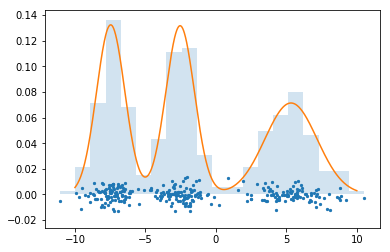

In [5]:
plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5)
plt.hist(x_train, bins=20, density=True, alpha=0.2)

x = np.linspace(-10, 10, 1000)
p = model(x[:, None])
plt.plot(x, p)
plt.show()

In [6]:
class GaussianMixtureEM(bn.Network):
    
    def __init__(self, n_component):
        super().__init__()
        with self.set_parameter():
            self.c = np.ones(n_component)
            self.mu = np.array([-10., 0., 10.])
            self.s = np.ones(n_component)
        
    def __call__(self, x, z=None):
        if z is None:
            return bn.random.GaussianMixture(bn.softmax(self.c), self.mu, bn.softplus(self.s), data=x).pdf().value
        self.pz = bn.random.Categorical(logit=bn.softmax(self.c), data=z)
        self.px = bn.random.GaussianMixture(z, self.mu, bn.softplus(self.s), data=x)
        return self.px.pdf().value * self.pz.pdf().value

In [7]:
model = GaussianMixtureEM(3)
optimizer = bn.optimizer.Adam(model, 1e-3)

for _ in range(10):
    resp = np.stack([model(x_train[:, None], np.eye(3)[i]) for i in range(3)], axis=-1)
    resp /= resp.sum(axis=-1, keepdims=True)
    for _ in range(1000):
        model.clear()
        model(x_train[:, None], resp)
        log_likelihood = model.log_pdf()
        log_likelihood.backward()
        optimizer.update()

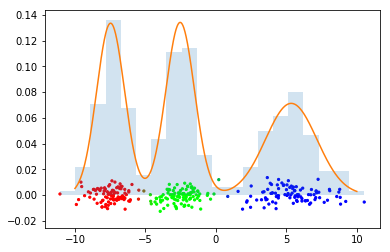

In [8]:
resp = np.stack([model(x_train[:, None], np.eye(3)[i]) for i in range(3)], axis=-1)
resp /= resp.sum(axis=-1, keepdims=True)
plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5, c=resp)
plt.hist(x_train, bins=20, density=True, alpha=0.2)

x = np.linspace(-10, 10, 1000)
p = model(x[:, None])
plt.plot(x, p)
plt.show()

In [9]:
class VariationalGaussianMixture(bn.Network):
    
    def __init__(self, n_component):
        self.n_component = n_component
        super().__init__()
        with self.set_parameter(), self.set_prior_dist():
            self.c=np.ones(n_component)
            self.m=np.linspace(-10, 10, n_component)
            self.s=np.ones(n_component)
            self.shape=np.ones(n_component)
            self.rate=np.ones(n_component)
            self.ptau = bn.random.Gamma(1., 1.)
        
    def gaussian(self, x, z):
        self.qtau = bn.random.Gamma(self.shape, self.rate, p=self.ptau)
        tau = self.qtau.draw()
        pmu = bn.random.Gaussian(0., tau=tau)
        self.qmu = bn.random.Gaussian(self.m, bn.softplus(self.s), p=pmu)
        self.px = bn.random.GaussianMixture(z, self.qmu.draw(), 1 / bn.sqrt(tau), data=x)

    def category(self, z):
        coef = bn.softmax(self.c)
        self.pc = bn.random.Dirichlet(np.ones(coef.shape), data=coef)
        self.pz = bn.random.Categorical(coef, data=z)
        
    def __call__(self, x, z=None):
        if z is None:
            self.gaussian(x, bn.softmax(self.c))
            return self.px.pdf().value
        self.category(z)
        self.gaussian(x, z)
        return self.pz.pdf().value * self.px.pdf().value

In [10]:
model = VariationalGaussianMixture(3)
optimizer_c = bn.optimizer.Adam([model.c], 1e-3)
optimizer_g = bn.optimizer.Adam([model.m, model.s, model.shape, model.rate], 1e-3)

for _ in range(10):
    resp = 0
    for _ in range(10):
        resp_ = np.stack(
            [model(x_train[:, None], np.eye(model.n_component)[i]) for i in range(model.n_component)],
            axis=-1
        )
        resp_ /= resp_.sum(axis=-1, keepdims=True)
        resp += resp_ / 10
    for _ in range(100):
        model.clear()
        model.category(resp)
        log_posterior = model.log_pdf()
        log_posterior.backward()
        optimizer_c.update()
    for _ in range(1000):
        model.clear()
        model.gaussian(x_train[:, None], resp)
        elbo = model.elbo()
        elbo.backward()
        optimizer_g.update()

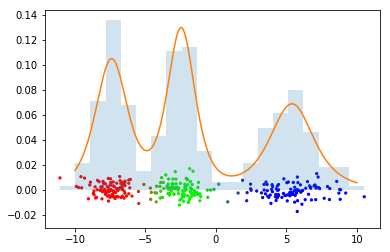

In [11]:
resp = 0
for _ in range(10):
    resp_ = np.stack(
        [model(x_train[:, None], np.eye(model.n_component)[i]) for i in range(model.n_component)],
        axis=-1
    )
    resp_ /= resp_.sum(axis=-1, keepdims=True)
    resp = resp + resp_ / 10
plt.scatter(x_train, np.random.normal(scale=0.005, size=x_train.size), s=5, c=resp)
plt.hist(x_train, bins=20, density=True, alpha=0.2)

x = np.linspace(-10, 10, 1000)
p = np.mean([model(x[:, None]) for _ in range(1000)], axis=0)
plt.plot(x, p)
plt.show()